In [148]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import sys
sys.path.append('..')
from pretty_midi_tokenization import notes_to_midi
import os
import pretty_midi
import collections

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',504)
pd.set_option('display.width',1000)


DRUM_MIDI_DICT = {    
    36: 'Kick',
    38: 'Snare',
    42: 'Closed Hi-Hat',
    43: 'Floor Tom',
    44: 'Pedal Hi-Hat',
    46: 'Open Hi-Hat',
    47: 'Tom 2',
    48: 'Tom 1',
    49: 'Crash',
    51: 'Ride'}

DIRECTORY_PATH = '..'
DATASET_PATH = os.path.join(DIRECTORY_PATH, 'dataset')
CHECKPOINTS_PATH = os.path.join(DIRECTORY_PATH, 'training_checkpoints')

# Model parameters
BATCH_SIZE = 4
EPOCHS = 50 
LEARNING_RATE = 0.001

# MIDI parameters
BPM = 120
BEATS_PER_BAR = 4
TICKS_PER_BEAT = 12
BAR_DURATION = BEATS_PER_BAR * (60 / BPM)

# Tokenization parameters
SEQ_LENGTH = BEATS_PER_BAR * TICKS_PER_BEAT
VELOCITY_RANGES = {'p': (0, 64), 'f': (65, 127)}
NOTE_START_TOKEN = 'S'
SILENCE_TOKEN = 'O'

In [142]:
def convert_time_to_ticks(time: float):
    pm = pretty_midi.PrettyMIDI(midi_file=None, resolution=TICKS_PER_BEAT, initial_tempo=BPM)
    return pm.time_to_tick(time)

def new_note(pitch, velocity, start, end, bar, convert_to_ticks = True):

    # NB: start and end are relative to the bar they are in
    if convert_to_ticks:
        start = convert_time_to_ticks(start - bar*BAR_DURATION)
        end = convert_time_to_ticks(end - bar*BAR_DURATION)

    new_note = {
        'pitch': pitch,
        'velocity': velocity,
        'start': start,
        'end': end,
        'bar': bar
    }
    
    return new_note


def append_note_to_notes_dict(notes: pd.DataFrame, note: dict):
    for key, value in note.items():
        notes[key].append(value)

In [143]:
def midi_to_note_bars(midi_file_path: str, bpm = BPM, beats_per_bar = BEATS_PER_BAR) -> pd.DataFrame:

  pm = pretty_midi.PrettyMIDI(midi_file_path)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list) # Dictionary with values as list
  bar_duration = (60/bpm) * beats_per_bar

  ticks_per_beat = pm.resolution
  print(f'Ticks per beat: {ticks_per_beat}')

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)

  for note in sorted_notes:

    pitch = note.pitch
    velocity = note.velocity
    start = note.start
    end = note.end
    # step = start - prev_start
    duration = end - start
    bar = int(start // bar_duration) # integer part of the division

    # split the note in two if it spans multiple bars
    if start + duration > (bar + 1) * bar_duration: 

      # update the current note to end at the end of the bar and update its duration
      note = new_note(pitch, velocity, start, (bar + 1) * bar_duration, bar)
      append_note_to_notes_dict(notes, note)

      # create new note in the succeeding bar with the remaining duration
      note = new_note(pitch, velocity, (bar + 1) * bar_duration, end, bar + 1)
      append_note_to_notes_dict(notes, note)

    else:
      note = new_note(pitch, velocity, start, end, bar)
      append_note_to_notes_dict(notes, note)

  # create a dataframe from the notes dictionary
  notes_df = pd.DataFrame({name: np.array(value) for name, value in notes.items()})

  # split notes into bars
  bars = []
  for bar_id in notes_df['bar'].unique():
    bar_df = notes_df[notes_df['bar'] == bar_id]
    bar_df = bar_df.reset_index(drop=True)

    # fill the beginning and end of each bar with empty notes if necessary

    if bar_df.loc[len(bar_df) - 1, 'end'] != SEQ_LENGTH:
      note = new_note(pitch = 0,
                      velocity = 0,
                      start = bar_df.loc[len(bar_df) - 1, 'end'],
                      end = SEQ_LENGTH,
                      bar = bar,
                      convert_to_ticks = False)
      bar_df = bar_df.append(note, ignore_index=True)

    if bar_df.at[0, 'start'] != 0:
      note = new_note(pitch = 0,
                      velocity = 0,
                      start = 0,
                      end = bar_df.at[0, 'start'],
                      bar = bar,
                      convert_to_ticks = False)
      bar_df = bar_df.append(note, ignore_index=True) 
      bar_df = bar_df.sort_values(by=['start']) 
      bar_df = bar_df.reset_index(drop=True)

    bars.append(bar_df)
  return bars

In [144]:
'''
Assumptions:
Sequences described as input_#.mid and output_#.mid in the corresponding folders
'''

input_filenames = glob.glob(os.path.join(DATASET_PATH, 'input/*.MID'))
print('Number of input files:', len(input_filenames))

output_filenames = glob.glob(os.path.join(DATASET_PATH, 'output/*.MID'))
print('Number of output files:', len(output_filenames))

for i, (in_file, out_file) in enumerate(zip(input_filenames, output_filenames)):

    in_file_name = os.path.basename(in_file)
    out_file_name = os.path.basename(out_file)
    print(f'\n{i + 1}: {in_file_name} -> {out_file_name}')

    in_bars = midi_to_note_bars(in_file)
    print(f'Number of bars in input: {len(in_bars)}')

    out_bars = midi_to_note_bars(out_file)
    print(f'Number of bars in output: {len(out_bars)}')


Number of input files: 1
Number of output files: 1

1: drum_excited.MID -> bass_example.MID
Ticks per beat: 12
Number of bars in input: 24
Ticks per beat: 12
Number of bars in output: 4


In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI(resolution=TICKS_PER_BEAT, initial_tempo=BPM)
  program = pretty_midi.instrument_name_to_program(instrument_name)
  instrument = pretty_midi.Instrument(program=program)

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [172]:
def tokenize_output_bars(bars: list)->sequences: list:

    '''Get a list of bars (pd.Dataframe) and return a list of sequences '''
    sequences = []
    for bar_df in bars:
        bar_sequence = np.empty((SEQ_LENGTH), dtype=object)
        bar_sequence[:] = SILENCE_TOKEN
        for i in range(len(bar_df)):
            note = bar_df.loc[i, 'pitch']
            if note != 0:
                start = bar_df.loc[i, 'start']
                end = bar_df.loc[i, 'end']
                bar_sequence[start] = str(note)+NOTE_START_TOKEN
                bar_sequence[start+1:end] = str(note)
        sequences.append(bar_sequence)

    flatten_sequences = np.concatenate(sequences)
    token_list = list(set(flatten_sequences))
    VOCAB_SIZE = len(token_list)
    print(f'Vocab size:{VOCAB_SIZE}')
    TOKENS = {}
    for i in range(0, len(token_list)):
        TOKENS[tokens[i]] = i

    for seq in sequences:
        for i in range(len(seq)):
            seq[i] = TOKENS[seq[i]] 
    
    return 

# out_file = '../output/test_1_bass.mid'
# out_pm = notes_to_midi(generated_notes, out_file=out_file, instrument_name='Acoustic Bass')

Vocab size:13
[8 8 6 6 6 6 6 10 10 8 6 10 10 4 7 7 7 7 7 10 4 7 7 10 11 12 12 12 12 12
 10 10 11 12 12 10 10 5 9 10 3 1 10 10 10 11 12 12]
[10 8 6 6 6 6 6 10 8 6 6 10 10 4 7 7 7 7 7 10 10 4 7 7 10 11 12 12 12 12
 12 10 10 11 12 10 10 5 9 9 10 3 1 10 11 12 12 12]
[10 8 6 6 6 6 6 10 8 6 6 10 4 7 7 7 7 7 10 10 4 7 10 10 11 12 12 12 12 12
 10 10 11 12 12 10 5 9 9 10 3 1 10 10 11 12 12 8]
[8 6 6 6 6 6 10 10 8 6 6 10 4 7 7 7 7 7 7 10 4 7 10 10 11 12 12 12 12 12
 10 0 2 2 10 5 9 9 10 3 1 10 11 12 12 10 10 10]


In [145]:
# def notes_tokenization(notes_df: pd.DataFrame, seq_length: int, vocab_range: list, key_order: list) -> pd.DataFrame:
for bar_df in out_bars:
    print(bar_df) 
    
for bar_df in in_bars:
    print(bar_df) 

   pitch  velocity  start  end  bar
0     43       127      0    1    0
1     43       127      1    7    0
2     43       127      9   11    0
3     47       127     13   19    0
4     47       127     20   23    0
5     50       127     24   30    0
6     50       127     32   35    0
7     53       127     37   39    0
8     52       127     40   42    0
9     50       127     45   48    0
   pitch  velocity  start  end  bar
0      0         0      0    1    3
1     43       127      1    7    1
2     43       127      8   11    1
3     47       127     13   19    1
4     47       127     21   24    1
5     50       127     25   31    1
6     50       127     33   35    1
7     53       127     37   40    1
8     52       127     41   43    1
9     50       127     44   48    1
    pitch  velocity  start  end  bar
0       0         0      0    1    3
1      43       127      1    7    2
2      43       127      8   11    2
3      47       127     12   18    2
4      47       127    

In [3]:
def create_sequences(
    in_bars: list,
    out_bars: list,  
    seq_length: int,
    vocab_range: list,
    vocab_size: int
) -> tf.data.Dataset:
  
  """
  Returns TF Dataset of sequence and label examples. 
  The latter is the next note of the sequence that has to be predicted.
  """

  key_order = KEY_ORDER
  max_step = 24
  max_duration = 24

  out_notes = pd.concat(out_bars)
  out_notes = np.stack([out_notes[key] for key in key_order], axis=1)

  in_notes = pd.concat(in_bars)
  in_notes = np.stack([in_notes[key] for key in key_order], axis=1) # get only 'key_order' columns from the dataframe

  # divide input into sequences of length `seq_length`shifted by 1 note each time
  sequences = []
  min_notes_length = min(len(in_notes), len(out_notes))
  num_sequences = min_notes_length - seq_length - 1
  for i in range(0, num_sequences):
    seq = in_notes[i:i+seq_length]
    label = np.array([out_notes[i+seq_length+1]])

    # print(seq.shape, label.shape)
    seq_and_label = np.concatenate((seq, label), axis=0)
    sequences.append(seq_and_label)

  # normalize only sequence values (not labels)
  sequences = np.stack(sequences, axis=0)
  sequences = sequences.astype(np.float32)

  sequences[:,:, 0] -= vocab_range[0]
  sequences[:,:-1, 0] /= vocab_size
  
  # get max values for step and duration to normalize them
  sequences[:,:-1, 1] /= max_step
  sequences[:,:-1, 2] /= max_duration

  # add 1 to seq_length to account for the label
  seq_length+=1 
  sequences = tf.data.Dataset.from_tensor_slices(sequences)
  
  # Split the labels from the input sequences
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(KEY_ORDER)}
    return inputs, labels
  
  sequences = sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

  return sequences, num_sequences, max_step, max_duration

In [6]:
# create sequences
sequences, num_sequences, max_step, max_duration = create_sequences(in_bars, out_bars, SEQ_LENGTH, VOCAB_RANGE, VOCAB_SIZE)

print('Number of sequences:', num_sequences)
for seq, target in sequences.take(1):
    print('sequence shape:', seq.shape)
    print('sequence first 3 elements:', seq[:20])
    print('target:', target)


Number of sequences: 17
sequence shape: (15, 3)
sequence first 3 elements: tf.Tensor(
[[0.16216215 0.         0.20833333]
 [0.         0.         0.20833333]
 [0.16216215 0.25       0.20833333]
 [0.05405406 0.25       0.20833333]
 [0.16216215 0.         0.20833333]
 [0.16216215 0.25       0.20833333]
 [0.         0.         0.20833333]
 [0.16216215 0.25       0.20833333]
 [0.16216215 0.25       0.20833333]
 [0.         0.         0.20833333]
 [0.05405406 0.25       0.20833333]
 [0.16216215 0.         0.20833333]
 [0.16216215 0.25       0.20833333]
 [0.05405406 0.125      0.20833333]
 [0.16216215 0.08333334 0.25      ]], shape=(15, 3), dtype=float32)
target: {'pitch': <tf.Tensor: shape=(), dtype=float32, numpy=17.0>, 'step_ticks': <tf.Tensor: shape=(), dtype=float32, numpy=4.0>, 'duration_ticks': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>}


In [8]:
def build_model(input_shape, learning_rate, max_step, max_duration):

    def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
        mse = (y_true - y_pred) ** 2
        positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
        return tf.reduce_mean(mse + positive_pressure)
    

    inputs = tf.keras.Input(input_shape)
    x = tf.keras.layers.LSTM(128)(inputs)
    outputs = {
    'pitch': tf.keras.layers.Dense(VOCAB_SIZE, name='pitch')(x),
    'step_ticks': tf.keras.layers.Dense(max_step, name='step')(x),
    'duration_ticks': tf.keras.layers.Dense(max_duration, name='duration')(x),
    }
    

    model = tf.keras.Model(inputs, outputs)

    loss = {
        'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        'step_ticks': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        'duration_ticks': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    }

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss=loss,
                  loss_weights={'pitch': 1.0, # 0.05
                                'step_ticks': 1.0,
                                'duration_ticks':1.0},
                  optimizer=optimizer)

    model.summary()

    return model

In [9]:
buffer_size = num_sequences  # the number of items in the dataset
dataset = (sequences
            .shuffle(buffer_size)
            .batch(BATCH_SIZE, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

input_shape = (SEQ_LENGTH, len(KEY_ORDER))

model = build_model(input_shape, LEARNING_RATE, max_step, max_duration)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = os.path.join(CHECKPOINTS_PATH, 'ckpt_{epoch}'),
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5, # Number of epochs with no improvement after which training will be stopped
        verbose=1,
        restore_best_weights=True),
]

dataset.element_spec

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 24)           3096        ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 37)           4773        ['lstm[0][0]']                   
                                                                                              

(TensorSpec(shape=(4, 15, 3), dtype=tf.float32, name=None),
 {'pitch': TensorSpec(shape=(4,), dtype=tf.float32, name=None),
  'step_ticks': TensorSpec(shape=(4,), dtype=tf.float32, name=None),
  'duration_ticks': TensorSpec(shape=(4,), dtype=tf.float32, name=None)})

In [10]:
losses = model.evaluate(dataset, return_dict=True)
losses

4/4 [==============================] - 1s 6ms/step - loss: 9.9273 - duration_loss: 3.1731 - pitch_loss: 3.5819 - step_loss: 3.1722


{'loss': 9.927299499511719,
 'duration_loss': 3.173142433166504,
 'pitch_loss': 3.5819311141967773,
 'step_loss': 3.172226667404175}

In [15]:
history = model.fit(
    dataset,
    epochs=100,
    callbacks=callbacks,
)

Epoch 1/100


4/4 [==============================] - 0s 28ms/step - loss: 2.7188 - duration_loss: 0.6919 - pitch_loss: 1.2926 - step_loss: 0.7344
Epoch 2/100
4/4 [==============================] - 0s 21ms/step - loss: 2.8189 - duration_loss: 0.8005 - pitch_loss: 1.2512 - step_loss: 0.7672
Epoch 3/100
4/4 [==============================] - 0s 22ms/step - loss: 2.8511 - duration_loss: 0.7738 - pitch_loss: 1.2727 - step_loss: 0.8046
Epoch 4/100
4/4 [==============================] - 0s 28ms/step - loss: 2.8165 - duration_loss: 0.7321 - pitch_loss: 1.2956 - step_loss: 0.7888
Epoch 5/100
4/4 [==============================] - 0s 21ms/step - loss: 2.7315 - duration_loss: 0.6838 - pitch_loss: 1.2714 - step_loss: 0.7763
Epoch 6/100
4/4 [==============================] - 0s 23ms/step - loss: 2.8879 - duration_loss: 0.7918 - pitch_loss: 1.3700 - step_loss: 0.7260
Epoch 6: early stopping


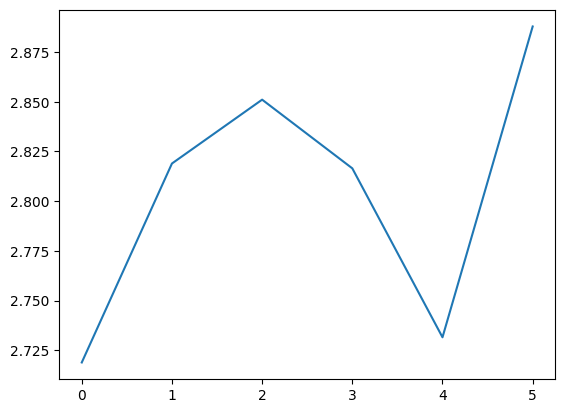

In [16]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [32]:
def predict_next_note(
    notes: np.ndarray, 
    model: tf.keras.Model, 
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step_logits = predictions['step_ticks']
  duration_logits = predictions['duration_ticks']
 
  # pitch = tf.argmax(pitch_logits, axis=-1)
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  pitch += VOCAB_RANGE[0] # add the minimum pitch value to get the actual pitch

  duration_logits /= temperature
  duration = tf.random.categorical(duration_logits, num_samples=1)
  duration = tf.squeeze(duration, axis=-1)

  step_logits /= temperature
  step = tf.random.categorical(step_logits, num_samples=1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), int(step), int(duration)




In [35]:
temperature = 2.0
num_predictions = 20

sample_notes = np.stack([in_notes[key] for key in KEY_ORDER], axis=1)
sample_notes = sample_notes.astype(np.float32)
sample_notes[:, 0] -= VOCAB_RANGE[0]
sample_notes[:, 0] /= VOCAB_SIZE
sample_notes[:, 1] /= max_step
sample_notes[:, 2] /= max_duration

# The initial sequence of notes; pitch is normalized 
input_notes = sample_notes[:SEQ_LENGTH]

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step_ticks, duration_ticks = predict_next_note(input_notes, model, temperature)
  pm = pretty_midi.PrettyMIDI(midi_file=None, resolution=12, initial_tempo=120)
  duration = pm.tick_to_time(duration_ticks)
  step = pm.tick_to_time(step_ticks)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

key_order = ['pitch', 'step', 'duration']
generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 45ms/step


In [36]:
# print(in_notes.head(20))

print(generated_notes.head(20))

    pitch      step  duration     start       end
0      47  0.166667  0.250000  0.166667  0.416667
1      43  0.208333  0.166667  0.375000  0.541667
2      43  0.208333  0.125000  0.583333  0.708333
3      47  0.166667  0.250000  0.750000  1.000000
4      53  0.166667  0.250000  0.916667  1.166667
5      43  0.166667  0.125000  1.083333  1.208333
6      43  0.166667  0.166667  1.250000  1.416667
7      49  0.166667  0.750000  1.416667  2.166667
8      53  0.166667  0.125000  1.583333  1.708333
9      43  0.208333  0.583333  1.791667  2.375000
10     39  0.375000  0.333333  2.166667  2.500000
11     50  0.208333  0.250000  2.375000  2.625000
12     50  0.166667  0.166667  2.541667  2.708333
13     50  0.166667  0.250000  2.708333  2.958333
14     42  0.166667  0.250000  2.875000  3.125000
15     43  0.375000  0.458333  3.250000  3.708333
16     43  0.375000  0.250000  3.625000  3.875000
17     47  0.166667  0.750000  3.791667  4.541667
18     43  0.375000  0.250000  4.166667  4.416667


In [38]:
out_file = '../output/generated_bass_output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name='Acoustic Bass')